In [1]:
import pandas as pd
import numpy as np
from src.hydraulic.config import DATA_PATH, SEPERATOR, PROFILE_COLUMNS, FILES_NAMES, DATA_OUTPUT_PATH
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

print(tf.__version__)

2.8.0


In [2]:
target = pd.read_csv(F'{DATA_PATH}/profile.txt', sep=SEPERATOR,  names=PROFILE_COLUMNS)
print(f"Target data array shape : {target.shape}")

train_idx, test_idx = train_test_split(target.index, test_size=.3, random_state=9)
test_idx, val_idx = train_test_split(test_idx, test_size=.5, random_state=9)

print(f"Train size: {len(train_idx)}")
print(f"Validation size: {len(val_idx)}")
print(f"Test size: {len(test_idx)}")

Target data array shape : (2205, 5)
Train size: 1543
Validation size: 331
Test size: 331


In [3]:
all_sensor_arrs = []
for sensor_type, data_file_names_list in FILES_NAMES.items():
    sensor_arr = []
    for file_name in data_file_names_list:
        ts_data = pd.read_csv(f'./data/{file_name}.txt', sep='\t', header=None)
        print(f"{sensor_type} - {file_name}: {ts_data.shape}")
        subjects_dim = ts_data.shape[0]
        observation_dim = ts_data.shape[1]
        sensor_arr.append(ts_data.values.reshape(subjects_dim, observation_dim, 1))
    all_sensor_arrs.append(np.concatenate(sensor_arr, axis=2))

# The inputs are observation_dim-length vectors with n sensors, and the batch size is subjects_dim.
# (m subjects, n sensors, p lenght of ts)
X_train = [data_arr[list(train_idx),:,:] for data_arr in all_sensor_arrs]
X_val = [data_arr[list(val_idx),:,:] for data_arr in all_sensor_arrs]
X_test = [data_arr[list(test_idx),:,:] for data_arr in all_sensor_arrs]

temperature - TS1: (2205, 60)
temperature - TS2: (2205, 60)
temperature - TS3: (2205, 60)
temperature - TS4: (2205, 60)
pressure - PS1: (2205, 6000)
pressure - PS2: (2205, 6000)
pressure - PS3: (2205, 6000)
pressure - PS4: (2205, 6000)
pressure - PS5: (2205, 6000)
pressure - PS6: (2205, 6000)
motor_power - EPS1: (2205, 6000)
volume_flow - FS1: (2205, 600)
volume_flow - FS2: (2205, 600)
vibration - VS1: (2205, 60)
cooling_efficiency - CE: (2205, 60)
cooling_power - CP: (2205, 60)
efficiency_factor - SE: (2205, 60)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-08-11 10:26:44.374602: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-11 10:26:44.374732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


model : 
	Input shape: (None, 60, 4) 
	Output Shape: (None, 28)
model_1 : 
	Input shape: (None, 6000, 6) 
	Output Shape: (None, 28)
model_2 : 
	Input shape: (None, 6000, 1) 
	Output Shape: (None, 28)
model_3 : 
	Input shape: (None, 600, 2) 
	Output Shape: (None, 28)
model_4 : 
	Input shape: (None, 60, 1) 
	Output Shape: (None, 28)
model_5 : 
	Input shape: (None, 60, 1) 
	Output Shape: (None, 28)
model_6 : 
	Input shape: (None, 60, 1) 
	Output Shape: (None, 28)
model_7 : 
	Input shape: (None, 60, 1) 
	Output Shape: (None, 28)


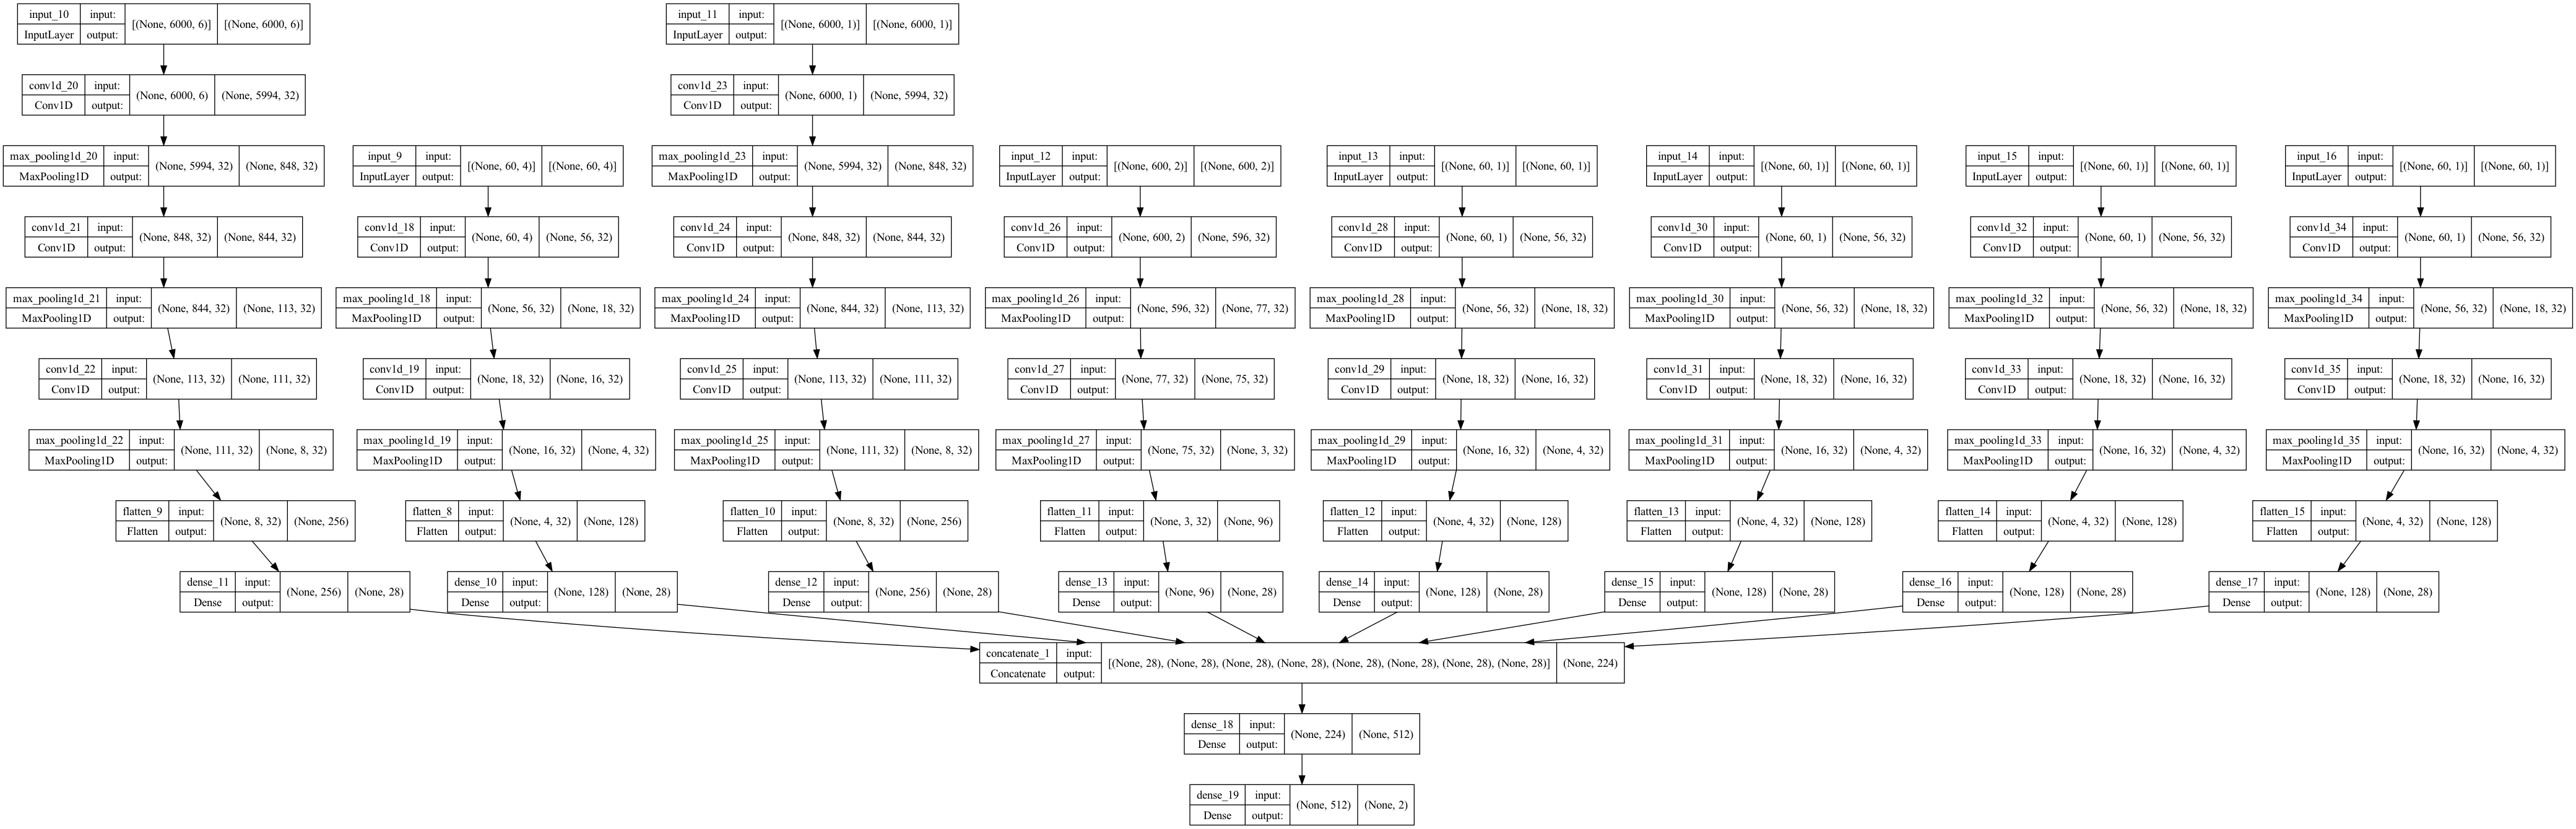

In [4]:
def mode_define(n_classes: int , print_shapes: bool =False):
    # temperature
    in_shape = tf.keras.layers.Input((60, 4))
    l1 = tf.keras.layers.Conv1D(32, 5, activation='relu')(in_shape)
    l2 = tf.keras.layers.MaxPooling1D(pool_size=5, strides=3, padding='valid')(l1)
    l3 = tf.keras.layers.Conv1D(32, 3, activation='relu')(l2)
    l4 = tf.keras.layers.MaxPooling1D(pool_size=5, strides=3, padding='valid')(l3)
    l5 = tf.keras.layers.Flatten()(l4)
    l5 = tf.keras.layers.Dense(28, activation='relu')(l5)
    temperature = tf.keras.Model(inputs=in_shape, outputs=l5)
    

    # pressure
    in_shape = tf.keras.layers.Input((6000, 6))
    l1 = tf.keras.layers.Conv1D(32, 7, activation='relu')(in_shape)
    l2 = tf.keras.layers.MaxPooling1D(pool_size=60, strides=7, padding='valid')(l1)
    l3 = tf.keras.layers.Conv1D(32, 5, activation='relu')(l2)
    l4 = tf.keras.layers.MaxPooling1D(pool_size=60, strides=7, padding='valid')(l3)
    l5 = tf.keras.layers.Conv1D(32, 3, activation='relu')(l4)
    l6 = tf.keras.layers.MaxPooling1D(pool_size=60, strides=7, padding='valid')(l5)
    l7 = tf.keras.layers.Flatten()(l6)
    l7 = tf.keras.layers.Dense(28, activation='relu')(l7)
    pressure = tf.keras.Model(inputs=in_shape, outputs=l7)
    
    # motor_power
    in_shape = tf.keras.layers.Input((6000, 1))
    l1 = tf.keras.layers.Conv1D(32, 7, activation='relu')(in_shape)
    l2 = tf.keras.layers.MaxPooling1D(pool_size=60, strides=7, padding='valid')(l1)
    l3 = tf.keras.layers.Conv1D(32, 5, activation='relu')(l2)
    l4 = tf.keras.layers.MaxPooling1D(pool_size=60, strides=7, padding='valid')(l3)
    l5 = tf.keras.layers.Conv1D(32, 3, activation='relu')(l4)
    l6 = tf.keras.layers.MaxPooling1D(pool_size=60, strides=7, padding='valid')(l5)
    l7 = tf.keras.layers.Flatten()(l6)
    l7 = tf.keras.layers.Dense(28, activation='relu')(l7)
    motor_power = tf.keras.Model(inputs=in_shape, outputs=l7)

    # volume_flow
    in_shape = tf.keras.layers.Input((600, 2))
    l1 = tf.keras.layers.Conv1D(32, 5, activation='relu')(in_shape)
    l2 = tf.keras.layers.MaxPooling1D(pool_size=60, strides=7, padding='valid')(l1)
    l3 = tf.keras.layers.Conv1D(32, 3, activation='relu')(l2)
    l4 = tf.keras.layers.MaxPooling1D(pool_size=60, strides=7, padding='valid')(l3)
    l5 = tf.keras.layers.Flatten()(l4)
    l5 = tf.keras.layers.Dense(28, activation='relu')(l5)
    volume_flow = tf.keras.Model(inputs=in_shape, outputs=l5)

    # vibration
    in_shape = tf.keras.layers.Input((60, 1))
    l1 = tf.keras.layers.Conv1D(32, 5, activation='relu')(in_shape)
    l2 = tf.keras.layers.MaxPooling1D(pool_size=5, strides=3, padding='valid')(l1)
    l3 = tf.keras.layers.Conv1D(32, 3, activation='relu')(l2)
    l4 = tf.keras.layers.MaxPooling1D(pool_size=5, strides=3, padding='valid')(l3)
    l5 = tf.keras.layers.Flatten()(l4)
    l5 = tf.keras.layers.Dense(28, activation='relu')(l5)
    vibration = tf.keras.Model(inputs=in_shape, outputs=l5)

    # cooling_efficiency
    in_shape = tf.keras.layers.Input((60, 1))
    l1 = tf.keras.layers.Conv1D(32, 5, activation='relu')(in_shape)
    l2 = tf.keras.layers.MaxPooling1D(pool_size=5, strides=3, padding='valid')(l1)
    l3 = tf.keras.layers.Conv1D(32, 3, activation='relu')(l2)
    l4 = tf.keras.layers.MaxPooling1D(pool_size=5, strides=3, padding='valid')(l3)
    l5 = tf.keras.layers.Flatten()(l4)
    l5 = tf.keras.layers.Dense(28, activation='relu')(l5)
    cooling_efficiency = tf.keras.Model(inputs=in_shape, outputs=l5)

    # cooling_power
    in_shape = tf.keras.layers.Input((60, 1))
    l1 = tf.keras.layers.Conv1D(32, 5, activation='relu')(in_shape)
    l2 = tf.keras.layers.MaxPooling1D(pool_size=5, strides=3, padding='valid')(l1)
    l3 = tf.keras.layers.Conv1D(32, 3, activation='relu')(l2)
    l4 = tf.keras.layers.MaxPooling1D(pool_size=5, strides=3, padding='valid')(l3)
    l5 = tf.keras.layers.Flatten()(l4)
    l5 = tf.keras.layers.Dense(28, activation='relu')(l5)
    cooling_power = tf.keras.Model(inputs=in_shape, outputs=l5)
    
    # efficiency_factor
    in_shape = tf.keras.layers.Input((60, 1))
    l1 = tf.keras.layers.Conv1D(32, 5, activation='relu')(in_shape)
    l2 = tf.keras.layers.MaxPooling1D(pool_size=5, strides=3, padding='valid')(l1)
    l3 = tf.keras.layers.Conv1D(32, 3, activation='relu')(l2)
    l4 = tf.keras.layers.MaxPooling1D(pool_size=5, strides=3, padding='valid')(l3)
    l5 = tf.keras.layers.Flatten()(l4)
    l5 = tf.keras.layers.Dense(28, activation='relu')(l5)
    efficiency_factor = tf.keras.Model(inputs=in_shape, outputs=l5)
    
    sernsors = [temperature, pressure, motor_power, volume_flow, vibration, cooling_efficiency, cooling_power, efficiency_factor]
    
    all_outputs = [i.output for i in sernsors]
    feature_concate = tf.keras.layers.Concatenate(axis=1)(all_outputs)
    x = tf.keras.layers.Dense(512, activation=tf.nn.relu)(feature_concate)
    final_layer = tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=[i.input for i in sernsors], outputs=final_layer)

    if print_shapes:
        for sensor in sernsors:
            print(f"{sensor.name} : \n\tInput shape: {sensor.input.shape} \n\tOutput Shape: {sensor.output.shape}")

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

    return model

model = mode_define(2, True)
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(mode_define(n_classes =2), to_file=dot_img_file, show_shapes=True)

In [5]:
for profile in PROFILE_COLUMNS:
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(target.loc[train_idx][profile])
    y_train = tf.keras.utils.to_categorical(y_train)

    y_val = encoder.transform(target.loc[val_idx][profile])
    y_val = tf.keras.utils.to_categorical(y_val)

    y_test = target.loc[test_idx][profile]

    model = mode_define(y_train.shape[1], False)
    model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

    model.fit(X_train, y_train, 
            epochs=500, 
            verbose=0, 
            validation_data=(X_val, y_val),
            callbacks=[model_early_stopping]
    )
    test_pred = encoder.inverse_transform(np.argmax(model.predict(X_test), axis=1))
    print(f"{profile} Accuracy : {accuracy_score(y_test, test_pred)}")

2023-08-11 10:26:45.548643: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-11 10:26:46.374231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 10:26:49.995900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 10:27:00.975485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


cooler Accuracy : 0.9969788519637462


2023-08-11 10:27:02.760184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 10:27:06.553381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 10:28:40.646450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


valve Accuracy : 1.0


2023-08-11 10:28:42.440018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 10:28:46.916143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 10:29:16.816773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


pump_lekage Accuracy : 0.6314199395770392


2023-08-11 10:29:18.758888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 10:29:23.508665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 10:29:47.284557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


accumulator Accuracy : 0.5861027190332326


2023-08-11 10:29:49.291430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 10:29:54.246920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 10:30:16.500404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


stable_flag Accuracy : 0.9003021148036254
